In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from datetime import datetime

import sys
from os.path import dirname, abspath
import os
sys.path.append(dirname(dirname(abspath('__file__')))+'/utils')

from sklearn.model_selection import train_test_split

from keras.layers import Dense, LeakyReLU, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Activation, BatchNormalization
from keras.models import Sequential, load_model
from keras.utils import to_categorical
from keras import optimizers
import keras
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

from check_performance import checkPerformance
from line_suppression import seg_line_sup

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
def NaiveApproach(data_sample):

    out = []
    sign = []
    indices = range(data_sample.shape[0])
    
    # 3 samples, mean    
    for i in range(4,data_sample.shape[0]-4):
        yn = data_sample
        ma = np.mean([yn[i-3], yn[i-2], yn[i-1]]) 
        mb = np.mean([yn[i+1], yn[i+2], yn[i+3]]) 
        thres = np.mean([(ma), (mb)]) + 0.75*18.1
        thres2 = np.mean([(ma), (mb)]) - 0.75*18.1
        o = (yn[i] > thres or  yn[i] < thres2 )
        out.append(o)
        if o and i in indices:
            if yn[i] >= thres:
                s = 1
            else:
                s = -1
            sign.append(s)
    
    results_tmp = np.where(out)[0] + 4
    results_naive = []
    for j in list(results_tmp):
        if j in indices:
            results_naive.append(j)
    
    return (results_naive, sign)

def correct_ts(data_sample):
    new_data_sample = data_sample.copy()
    result_idxs, signs = NaiveApproach(data_sample)
    res = zip(result_idxs, signs)
    for idx, sign in res:
        new_data_sample[idx] += -1 * sign * 18.1 
    return new_data_sample

In [3]:
## Input the filenames and parameters:
filename = 'segmented_ts_sim_with_UE_02.pkl'
original_indices = 'orig_x.npy'
full_indices = 'full_time_index.npy'
interpolation_method = 'original'

In [4]:
## Create variables with directories to external files:
directory = os.path.join(dirname(os.getcwd()), 'data_files/')
file_data = os.path.join(directory, filename)
file_full_indices = os.path.join(directory, full_indices)
file_orig_indices = os.path.join(directory, original_indices)

In [5]:
## Import the measurements:
data_imported = pd.read_pickle(file_data)
data_df = data_imported['time-series with UE']

## Correct the unwrapping errors
data_df_corrected = data_df.map(correct_ts)

## Load and calculate x-axis index:
orig_x = np.load(file_orig_indices)
full_x = np.load(file_full_indices) 
indices = [int(i*365.25/11) for i in orig_x]

## Load the answers (ground truth):
points = pd.DataFrame(data_imported['list of UE'], index = data_imported.index)
points.columns = ['points']
segm_lines = pd.DataFrame(data_imported['segm_lines'], index = data_imported.index)
segm_lines.columns = ['segm_lines']

In [10]:
record_num = len(data_df_corrected)
record_length = len(data_df_corrected.iloc[0])

## Reshape the data from DataFrame into an array
data = np.zeros((record_num, record_length))
for idx, ar in enumerate(data_df_corrected.values):
    data[idx, :] = ar

In [11]:
ans_pt = np.zeros((record_num, record_length))
for idx, l in enumerate(points.values):
    for p in l[0]:
        ans_pt[idx, p] = 1

In [12]:
ans_seg = np.zeros((record_num, record_length))
for idx, l in enumerate(segm_lines.values):
    for s in l[0]:
        ans_seg[idx, s] = 1

In [166]:
test_ratio = 0.1
val_ratio = 0.2
# val_ratio_adj = (val_ratio / (1 - test_ratio))
val_ratio_adj = 0.22222222

X_train, X_test, y_train, y_test = train_test_split(data, ans_seg, test_size=test_ratio, random_state=133)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio_adj, random_state=133)

print("Data split shape check:")
print(f"X_train shape: {X_train.shape} - {round(1 - test_ratio - val_ratio)*100}%")
print(f"y_train shape: {y_train.shape} - {round(1 - test_ratio - val_ratio)*100}%")
print(f"X_val shape: {X_val.shape} - {int(val_ratio*100)}%")
print(f"y_val shape: {y_val.shape} - {int(val_ratio*100)}%")
print(f"X_test shape: {X_test.shape} - {int(test_ratio*100)}%")
print(f"y_test shape: {y_test.shape} - {int(test_ratio*100)}%")

Data split shape check:
X_train shape: (7000, 297) - 100%
y_train shape: (7000, 297) - 100%
X_val shape: (2000, 297) - 20%
y_val shape: (2000, 297) - 20%
X_test shape: (1000, 297) - 10%
y_test shape: (1000, 297) - 10%


In [167]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/{datetime.now().strftime('%Y%m%d-%H%M%S')}/")
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=100,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [168]:
scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()
scaler_val = MinMaxScaler()

X_train_scaled = scaler_train.fit_transform(X_train.T).T
X_test_scaled = scaler_test.fit_transform(X_test.T).T
X_val_scaled = scaler_val.fit_transform(X_val.T).T

In [169]:
loss = tf.keras.losses.BinaryCrossentropy(
    from_logits=False, label_smoothing=0, reduction="auto", name="binary_crossentropy"
)
m_prec = tf.keras.metrics.Precision()
m_rec = tf.keras.metrics.Recall()

In [170]:
X_train.shape

(7000, 297)

In [176]:
model = Sequential()
model.add(Input(shape=(297,1)))
model.add(Conv1D(filters=64, kernel_size=15))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv1D(filters=128, kernel_size=9))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=192, kernel_size=5))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv1D(filters=256, kernel_size=5))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=512, kernel_size=3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dense(2048))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Dropout(0.3))
model.add(Activation('relu'))
model.add(Dense(297, activation='sigmoid'))

adam = optimizers.Adam(lr = 0.0001)
model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])

In [172]:
X_train_exp = np.expand_dims(X_train_scaled, axis=-1)

In [173]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 283, 64)           1024      
_________________________________________________________________
batch_normalization_22 (Batc (None, 283, 64)           256       
_________________________________________________________________
activation_29 (Activation)   (None, 283, 64)           0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 275, 128)          73856     
_________________________________________________________________
batch_normalization_23 (Batc (None, 275, 128)          512       
_________________________________________________________________
activation_30 (Activation)   (None, 275, 128)          0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 137, 128)         

In [174]:
X_train_exp.shape

(7000, 297, 1)

In [202]:
# model.save("raw_cnn_model_04")

INFO:tensorflow:Assets written to: raw_cnn_model_04/assets


In [177]:
model_train = model.fit(X_train_exp, y_train, 
                        batch_size=32, 
                        validation_split=0.2, 
                        epochs=250, 
                        callbacks=[tensorboard_callback, early_stopping_monitor],
                       )

Epoch 1/250
175/175 [==============================] - 6s 31ms/step - loss: 0.1456 - accuracy: 0.0030 - val_loss: 0.0719 - val_accuracy: 0.0036
Epoch 2/250
175/175 [==============================] - 5s 29ms/step - loss: 0.0358 - accuracy: 0.0011 - val_loss: 0.0359 - val_accuracy: 0.0050
Epoch 3/250
175/175 [==============================] - 5s 29ms/step - loss: 0.0345 - accuracy: 0.0032 - val_loss: 0.0354 - val_accuracy: 0.0079
Epoch 4/250
175/175 [==============================] - 5s 29ms/step - loss: 0.0336 - accuracy: 0.0064 - val_loss: 0.0366 - val_accuracy: 0.0036
Epoch 5/250
175/175 [==============================] - 5s 29ms/step - loss: 0.0336 - accuracy: 0.0028 - val_loss: 0.0325 - val_accuracy: 0.0057
Epoch 6/250
175/175 [==============================] - 5s 29ms/step - loss: 0.0323 - accuracy: 0.0054 - val_loss: 0.0333 - val_accuracy: 0.0050
Epoch 7/250
175/175 [==============================] - 5s 29ms/step - loss: 0.0321 - accuracy: 0.0100 - val_loss: 0.0347 - val_accuracy:

In [198]:
pred = model_train.model.predict(np.expand_dims(X_test_scaled, axis=-1))

In [199]:
thresh = 0.1

pred_list = np.where(pred > thresh)[0]
print(len(set(pred_list)))
print(pred_list)

answers = [list(np.where(item > thresh)[0]) for item in pred]
# gt = [list(np.where(gt_item > 0)[0]) for gt_item in y_val]
gt = [list(np.where(gt_item > 0)[0]) for gt_item in y_test]
answers_scores =  [[pred[k][i] for i in ans] for k, ans in enumerate(answers)]
answers_sup = [seg_line_sup(ans, vals) for ans, vals in zip(answers, answers_scores)]

484
[  0   0   0 ... 999 999 999]


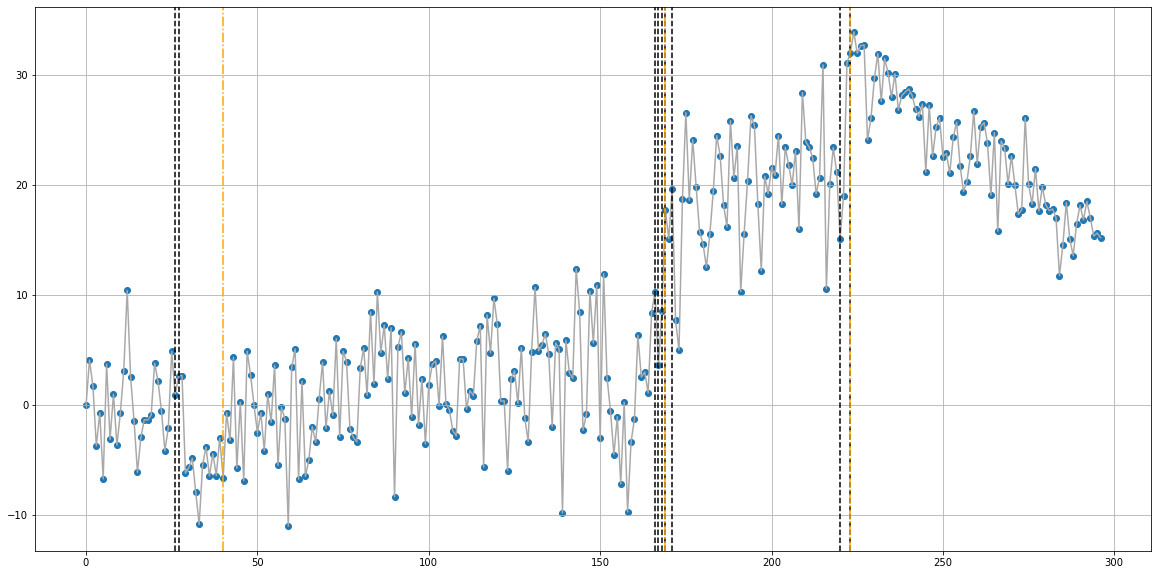

In [233]:
ts = 41

plt.figure(figsize=(20,10))
plt.plot(X_test[ts], color='darkgrey')
plt.scatter(range(297), X_test[ts])
# for i, val in enumerate(pred[ts]):
#     if val == 1:
#         plt.gca().axvline(i, linestyle='--', color='black')
for i in answers[ts]:
    plt.gca().axvline(i, linestyle='--', color='black')
for j in gt[ts]:
    plt.gca().axvline(j, linestyle='-.', color='orange')
plt.grid()

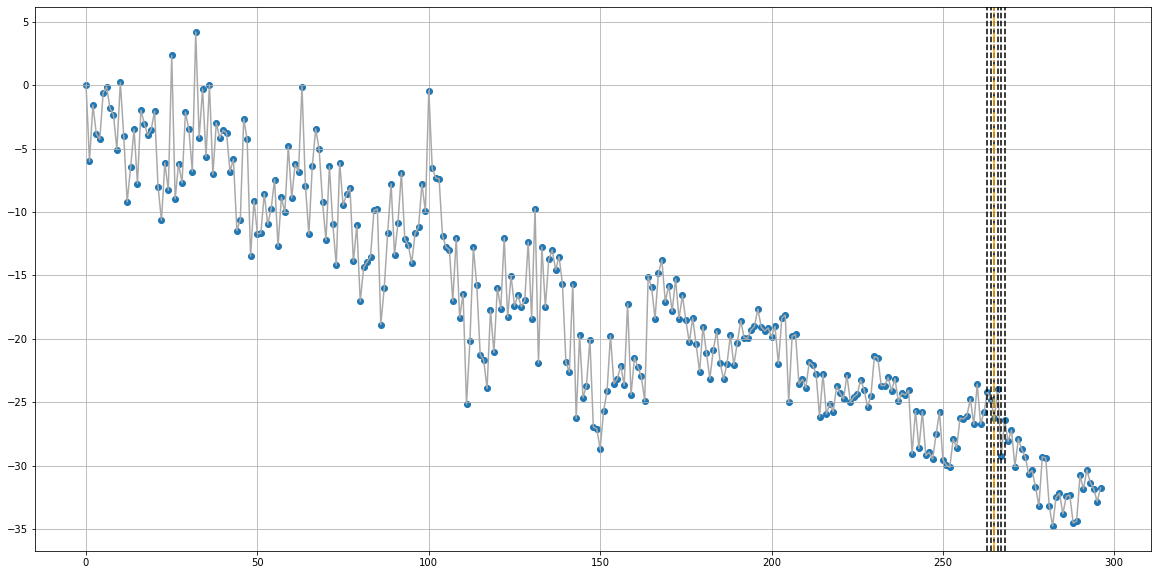

In [221]:
ts = 46

plt.figure(figsize=(20,10))
plt.plot(X_val[ts], color='darkgrey')
plt.scatter(range(297), X_val[ts])
# for i, val in enumerate(pred[ts]):
#     if val == 1:
#         plt.gca().axvline(i, linestyle='--', color='black')
for i in answers[ts]:
    plt.gca().axvline(i, linestyle='--', color='black')
for j in gt[ts]:
    plt.gca().axvline(j, linestyle='-.', color='orange')
plt.grid()

In [200]:
recalls = []
precisions = []
TPall = []
FPall = []
FNall = []
    
for l in range(pred.shape[0]):
    r, p, tp, fp, fn = checkPerformance(answers[l], gt[l], tolerance = 5)
    recalls.append(r)
    precisions.append(p)
    TPall.append(tp)
    FPall.append(fp)
    FNall.append(fn)

print("Overall scores")
print()
print('recall:', np.nanmean(recalls))
print('precision:',np.nanmean(precisions), '\n')
print()
print('TPall: ', sum(TPall))
print('FPall: ', sum(FPall))
print('FNall: ', sum(FNall))
print()
print('recall:',sum(TPall)/(sum(TPall) + sum(FNall)))
print('precision:',sum(TPall)/(sum(TPall) + sum(FPall)), '\n')
print('-------------------------------------')

recalls = []
precisions = []
TPall = []
FPall = []
FNall = []
    
for l in range(pred.shape[0]):
    r, p, tp, fp, fn = checkPerformance(answers_sup[l], gt[l], tolerance = 5)
    recalls.append(r)
    precisions.append(p)
    TPall.append(tp)
    FPall.append(fp)
    FNall.append(fn)


print("Scores with non-minimum suppression")
print()
print('recall:', np.nanmean(recalls))
print('precision:',np.nanmean(precisions), '\n')
print()
print('TPall: ', sum(TPall))
print('FPall: ', sum(FPall))
print('FNall: ', sum(FNall))
print()
print('recall:',sum(TPall)/(sum(TPall) + sum(FNall)))
print('precision:',sum(TPall)/(sum(TPall) + sum(FPall)), '\n')
print('-------------------------------------')

Overall scores

recall: 0.3731211317418214
precision: 0.3052679414249662 


TPall:  559
FPall:  1712
FNall:  940

recall: 0.37291527685123416
precision: 0.24614707177454867 

-------------------------------------
Scores with non-minimum suppression

recall: 0.371131741821397
precision: 0.659555785123967 


TPall:  555
FPall:  425
FNall:  944

recall: 0.37024683122081387
precision: 0.5663265306122449 

-------------------------------------


max pred value: 0.9996421337127686


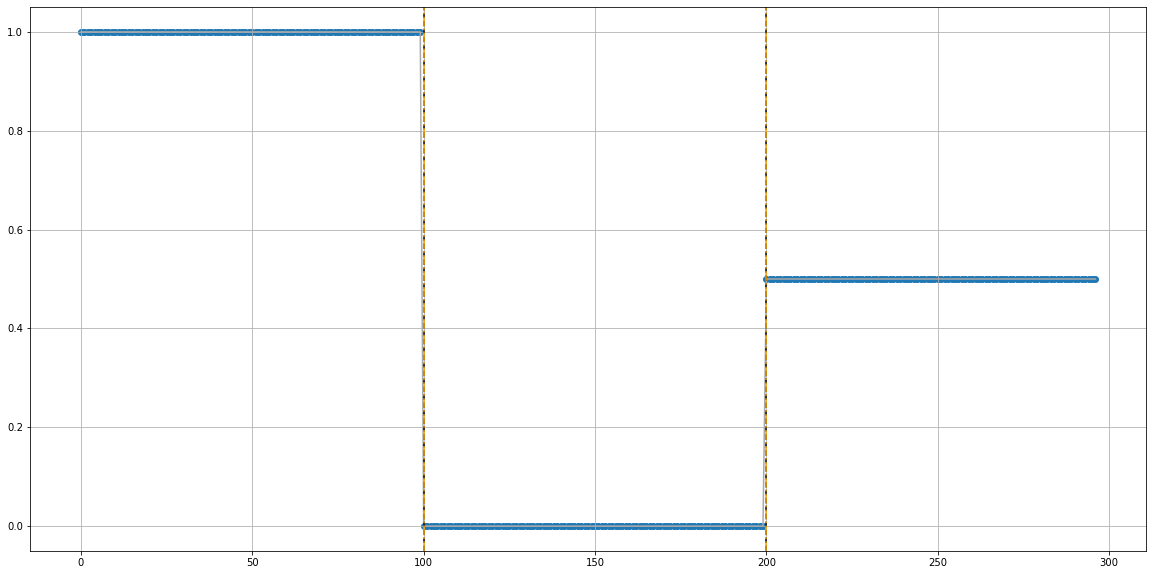

In [126]:
X_triv = np.zeros((297))
X_triv[0:100] = 1
X_triv[200:] = 0.5

pred_triv = model_train.model.predict(np.expand_dims(X_triv.reshape(1, -1), axis=-1))

print(f"max pred value: {max(pred_triv[0])}")

plt.figure(figsize=(20,10))
plt.plot(X_triv, color='darkgrey')
plt.scatter(range(297), X_triv)
for i in np.where(pred_triv > 0.1)[1]:
    plt.gca().axvline(i, linestyle='--', color='black')
for j in [100, 200]:
    plt.gca().axvline(j, linestyle='-.', color='orange')
plt.grid()

In [ ]:
X_triv = np.zeros((297))
X_triv[0:100] = 1
X_triv[200:] = 0.5

pred_triv = model_train.model.predict(np.expand_dims(X_triv.reshape(1, -1), axis=-1))

print(f"max pred value: {max(pred_triv[0])}")

plt.figure(figsize=(20,10))
plt.plot(X_triv, color='darkgrey')
plt.scatter(range(297), X_triv)
for i in np.where(pred_triv > 0.19)[1]:
    plt.gca().axvline(i, linestyle='--', color='black')
for j in [100, 200]:
    plt.gca().axvline(j, linestyle='--', color='orange')
plt.grid()